## Streaming

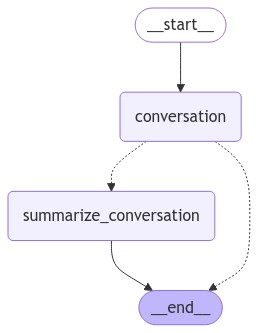

In [1]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

class State(MessagesState):
    summary: str

def call_model(state: State, config: RunnableConfig):
    summary = state.get("summary", "")

    if summary:
        system_message = f"これまでの会話の要約です: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)

    return {"messages": response}


def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"これまでの会話の要約は以下の通りです: {summary}\n\n"
            "上記の新しいメッセージを考慮して要約を更新してください:"
        )
    else:
        summary_message = "上記の会話の要約を作成してください:"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 最新の2つの会話を残して残りを削除する
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


def should_continue(state: State):
    messages = state["messages"]

    # メッセージが増えたら要約を作成する
    if len(messages) > 6:
        return "summarize_conversation"

    return END

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### ノードレベルのストリーム

In [2]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream({"messages": [HumanMessage(content="やあ！私はLanceです。")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='やあ、Lanceさん！お会いできて嬉しいです。今日はどんなことを話しましょうか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-e2643ddd-bb5e-4306-bb16-3b88424b1d0f-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})}}


In [3]:
for chunk in graph.stream({"messages": [HumanMessage(content="やあ！私はLanceです。")]}, config, stream_mode="updates"):
    chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

こんにちは、Lanceさん！再びお会いできて嬉しいです。何か特別なことについて話したいことがありますか？それとも、何か質問がありますか？


In [9]:
config = {"configurable": {"thread_id": "3"}}

input_message = HumanMessage(content="こんにちは！私はLanceです。")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("---" * 25)

================================ Human Message =================================

こんにちは！私はLanceです。
---------------------------------------------------------------------------
================================ Human Message =================================

こんにちは！私はLanceです。
================================== Ai Message ==================================

こんにちは、Lanceさん！お会いできて嬉しいです。今日はどんなことをお話ししましょうか？
---------------------------------------------------------------------------


### トークンレベルのストリーム

In [16]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="LangGraphのトークンレベルストリームについて一言で教えて")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f'Node: {event["metadata"].get("langgraph_node", "")}. Type: {event["event"]}. Name: {event["name"]}')

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: 

In [17]:
config = {"configurable": {"thread_id": "7"}}
input_message = HumanMessage(content="LangGraphのトークンレベルストリームについて一言で教えて")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == "conversation":
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-cce81353-86a3-4d27-b8e2-f53629aeeafc')}
{'chunk': AIMessageChunk(content='Lang', additional_kwargs={}, response_metadata={}, id='run-cce81353-86a3-4d27-b8e2-f53629aeeafc')}
{'chunk': AIMessageChunk(content='Graph', additional_kwargs={}, response_metadata={}, id='run-cce81353-86a3-4d27-b8e2-f53629aeeafc')}
{'chunk': AIMessageChunk(content='の', additional_kwargs={}, response_metadata={}, id='run-cce81353-86a3-4d27-b8e2-f53629aeeafc')}
{'chunk': AIMessageChunk(content='ト', additional_kwargs={}, response_metadata={}, id='run-cce81353-86a3-4d27-b8e2-f53629aeeafc')}
{'chunk': AIMessageChunk(content='ーク', additional_kwargs={}, response_metadata={}, id='run-cce81353-86a3-4d27-b8e2-f53629aeeafc')}
{'chunk': AIMessageChunk(content='ン', additional_kwargs={}, response_metadata={}, id='run-cce81353-86a3-4d27-b8e2-f53629aeeafc')}
{'chunk': AIMessageChunk(content='レ', additional_kwargs={}, response_metadata={}, i

In [18]:
config = {"configurable": {"thread_id": "8"}}
input_message = HumanMessage(content="LangGraphのトークンレベルストリームについて一言で教えて")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == "conversation":
        data = event["data"]
        print(data["chunk"].content, end="|")

|Lang|Graph|の|ト|ーク|ン|レ|ベル|スト|リ|ーム|は|、|言|語|モデル|が|生成|する|テ|キ|スト|を|ト|ーク|ン|単|位|で|リア|ル|タイ|ム|に|処|理|・|出|力|する|機|能|です|。||

## Breakpoints: ノードの実行を一時停止する

In [1]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

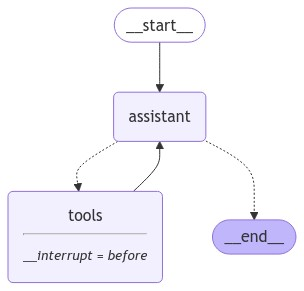

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


sys_msg = SystemMessage(content="あなたは一連の入力に対して算術計算を行うことを任務とする、役立つアシスタントです。")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
initial_input = {"messages": HumanMessage(content="2かける3は？")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2かける3は？
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lfREe1d0YBOmqz1vaCny5Ybi)
 Call ID: call_lfREe1d0YBOmqz1vaCny5Ybi
  Args:
    a: 2
    b: 3


In [16]:
state = graph.get_state(thread)
state.next

('tools',)

In [17]:
# Noneを入力すると停止したノードから再開される
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_lfREe1d0YBOmqz1vaCny5Ybi)
 Call ID: call_lfREe1d0YBOmqz1vaCny5Ybi
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2かける3は6です。


In [21]:
# Toolを使うまえにユーザの確認をはさむ
initial_input = {"messages": HumanMessage(content="2かける3は？")}

thread = {"configurable": {"thread_id": "2"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

user_approval = input("ツールを呼び出したいですか？ (yes/no): ")

if user_approval.lower() == "yes":
    for event in graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()
else:
    print("ユーザによってツール実行がキャンセルされました")

================================ Human Message =================================

2かける3は？
================================== Ai Message ==================================
Tool Calls:
  multiply (call_r430MFjvammxAajZgpGg9Daj)
 Call ID: call_r430MFjvammxAajZgpGg9Daj
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_r430MFjvammxAajZgpGg9Daj)
 Call ID: call_r430MFjvammxAajZgpGg9Daj
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2かける3は6です。


## Editing State: ノードの状態を修正する

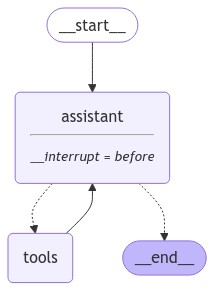

In [3]:
# Breakpointで実行を止めて状態を修正できる
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(content="あなたは一連の入力に対して算術計算を行うことを任務とする、役立つアシスタントです。")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
# LLMの実行の直前で止める
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
initial_input = {"messages": HumanMessage(content="2かける3は？")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2かける3は？


In [ ]:
# 状態の更新
# idを指定すれば既存のメッセージを上書きできるがここでは追加
graph.update_state(
    thread,
    # Reducerによってmessagesが追加される
    {"messages": [HumanMessage(content="間違えた。3かける3は？")]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef96805-6039-6c25-8001-9194297bf209'}}

In [6]:
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

2かける3は？
================================ Human Message =================================

間違えた。3かける3は？


In [7]:
# 続きから再開する
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

間違えた。3かける3は？
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4Cqhf9tiy1x4AxuVcmGhyNuX)
 Call ID: call_4Cqhf9tiy1x4AxuVcmGhyNuX
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


## 人間によるフィードバックノードを追加する

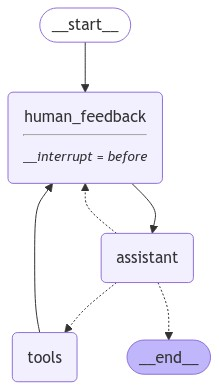

In [ ]:
# Breakpointで実行を止めて状態を修正できる
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(content="あなたは一連の入力に対して算術計算を行うことを任務とする、役立つアシスタントです。")

def human_feedback(sate: MessagesState):
    # 実際の状態の更新処理はグラフ実行時に書く
    pass

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
# LLMの実行の直前で止める
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
initial_input = {"messages": HumanMessage(content="2かける3は？")}

thread = {"configurable": {"thread_id": "6"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# 人間のフィードバック（状態の更新）
user_input = input("どのように状態更新したいか教えてください: ")
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2かける3は？
================================ Human Message =================================

3*3は
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0wvF5Djlaf2Aq45iJvfEDShA)
 Call ID: call_0wvF5Djlaf2Aq45iJvfEDShA
  Args:
    a: 2
    b: 3
  multiply (call_tbuUjtLjLgvd93yOJYtEW4DC)
 Call ID: call_tbuUjtLjLgvd93yOJYtEW4DC
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


## 動的なノードの停止（NodeInterrupt）

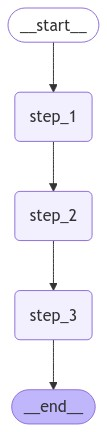

In [19]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("--- Step 1 ---")
    return state

def step_2(state: State) -> State:
    if len(state["input"]) > 5:
        raise NodeInterrupt(f"入力が5文字より長いです: {state['input']}")

    print("--- Step 2 ---")
    return state

def step_3(state: State) -> State:
    print("--- Step 3 ---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
--- Step 1 ---
{'input': 'hello world'}


In [21]:
state = graph.get_state(thread_config)
state.next

('step_2',)

In [22]:
state.tasks

(PregelTask(id='9f3e95a9-6a03-9538-17cb-d8d6252b8289', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='入力が5文字より長いです: hello world', when='during'),), state=None, result=None),)

In [23]:
# 続きから始めるが何もしないと同じノードで止まる
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


In [24]:
# 状態を修正
graph.update_state(thread_config, {"input": "hi"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef96869-5c43-6956-8002-9b2490262a78'}}

In [25]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
--- Step 2 ---
{'input': 'hi'}
--- Step 3 ---
{'input': 'hi'}


## タイムトラベル

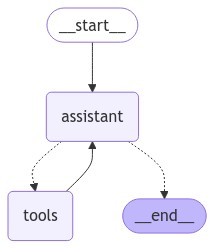

In [72]:
# Breakpointで実行を止めて状態を修正できる
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(content="あなたは一連の入力に対して算術計算を行うことを任務とする、役立つアシスタントです。")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [73]:
initial_input = {"messages": HumanMessage(content="2かける3は？")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2かける3は？
================================== Ai Message ==================================
Tool Calls:
  multiply (call_B8sWEUSNDmJtPxj9m84w1vlh)
 Call ID: call_B8sWEUSNDmJtPxj9m84w1vlh
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2かける3は6です。


In [74]:
# スレッドの現在の状態を調べる
snapshot = graph.get_state(thread)
snapshot.values["messages"]

[HumanMessage(content='2かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bfc6a7dc2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e7dd022a-a272-4a77-b21a-ab1ebe6bca53-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}, 'output_t

In [75]:
all_states = [s for s in graph.get_state_history(thread)]
len(all_states)

5

In [76]:
# インデックスが小さいほど新しい状態
all_states[0].values["messages"]

[HumanMessage(content='2かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bfc6a7dc2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e7dd022a-a272-4a77-b21a-ab1ebe6bca53-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}, 'output_t

In [77]:
# 1つ前の状態
all_states[1].values["messages"]

[HumanMessage(content='2かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bfc6a7dc2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e7dd022a-a272-4a77-b21a-ab1ebe6bca53-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}, 'output_t

In [78]:
# 2つ前の状態
all_states[2].values["messages"]

[HumanMessage(content='2かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bfc6a7dc2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e7dd022a-a272-4a77-b21a-ab1ebe6bca53-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}, 'output_t

In [79]:
# リプレイ
to_replay = all_states[1]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='2かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bfc6a7dc2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e7dd022a-a272-4a77-b21a-ab1ebe6bca53-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166, 'input_token_detai

In [80]:
to_replay.values["messages"]

[HumanMessage(content='2かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bfc6a7dc2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e7dd022a-a272-4a77-b21a-ab1ebe6bca53-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_B8sWEUSNDmJtPxj9m84w1vlh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}, 'output_t

In [81]:
to_replay.next

('assistant',)

In [82]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef96901-4473-6f2e-8002-7e1d466d4cb5'}}

In [ ]:
# configを指定するとそこから開始できる
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2かける3は6です。


## Forking: 巻き戻して状態を変更して再開する

In [84]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='2かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26')]

In [85]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef96901-3da6-63e5-8000-a919557a6ca7'}}

In [86]:
# messagesを上書きする
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content="5かける3は？", id=to_fork.values["messages"][0].id)]}
)
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9690b-c484-6d1d-8001-9c89254832ad'}}

In [ ]:
# 状態が更新され巻き戻っているのがわかる
all_states = [state for state in graph.get_state_history(thread)]
all_states[0].values["messages"]

[HumanMessage(content='5かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26')]

In [ ]:
# 現在の状態も巻き戻っている
graph.get_state({"configurable": {"thread_id": "1"}}).values["messages"]

[HumanMessage(content='5かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26')]

In [89]:
# 巻き戻しから再開
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

5かける3は？
================================== Ai Message ==================================
Tool Calls:
  multiply (call_n9pSc6uJuzp9ft763ocnHEP4)
 Call ID: call_n9pSc6uJuzp9ft763ocnHEP4
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

5かける3は15です。


In [90]:
graph.get_state({"configurable": {"thread_id": "1"}}).values["messages"]

[HumanMessage(content='5かける3は？', additional_kwargs={}, response_metadata={}, id='b3a0c6df-0c08-4487-8dbe-b93f35e36a26'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n9pSc6uJuzp9ft763ocnHEP4', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d2762c68-6171-490e-985d-d8c1a7e2e1b3-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_n9pSc6uJuzp9ft763ocnHEP4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}, 'output_t